# Dataset import

In [1]:
# Math and linear algebra
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
import math
import numpy as np

# Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Utils
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
import gc

FLAG_EXPORT = True
FLAG_DEBUG = False
FLAG_LIMIT_N = None #2000

out_path = 'assets/'

In [2]:
# Import training dataset
raw = pd.read_csv ("../../datasets/brasilia_case_preprocessed.csv", header=0)

raw = raw.drop('timestamp', axis=1)
raw.tail()

,temperature,pressure,precipitation,windspeed,voltage,cos_phi,cos_phi_std,month,hour,day_of_week,p3_std,load_factor,p3
84921,0.044226,-0.250199,-0.178382,-1.997069,0.847423,-0.704650,-0.285084,1.861182,1.510864,0.99741,-0.758144,-0.316169,70.696167
84922,0.004726,-0.246156,-0.178382,-1.918821,1.081712,-0.766661,1.083955,1.861182,1.510864,0.99741,0.319896,-2.984903,74.598750
84923,-0.041956,-0.248695,-0.178382,-1.800332,1.381961,-0.880834,0.170989,1.861182,1.510864,0.99741,-0.873229,0.870345,70.590538
84924,-0.095821,-0.258380,-0.178382,-1.655015,1.197738,-0.985090,2.885395,1.861182,1.510864,0.99741,0.168539,-1.281150,70.484667
84925,-0.156867,-0.275775,-0.178382,-1.496284,1.238225,-0.988345,0.757411,1.861182,1.655251,0.99741,-0.714790,0.524732,68.601167


In [3]:
from sklearn.model_selection import train_test_split

X = raw.drop('p3', axis=1)
y = raw ['p3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

if FLAG_LIMIT_N:
    n = FLAG_LIMIT_N
    X_train = X_train[:n]
    X_test = X_test[:n]
    y_train = y_train[:n]
    y_test = y_test[:n]

del X
del y
gc.collect()

10

In [4]:
def regression_report (y_hat, y_test, alpha=0.05, title="Model Evaluation"):
    print ("MAE:                ", metrics.mean_absolute_error(y_test, y_hat))
    print ("RMSE:               ", np.sqrt(metrics.mean_squared_error(y_test, y_hat)))
    print ("Percentual:         ", metrics.mean_absolute_error(y_test,y_hat)/y_test.mean()*100, "%")

    # Previsto vs real
    line = np.arange(np.min([y_test, y_hat]),
                     np.max([y_test, y_hat]),
                     1)

    plt.scatter(y_test,y_hat, Alpha=alpha)
    plt.scatter(line,line, marker='.')
    plt.grid(True)
    plt.title(title)
    plt.xlabel("Real values")
    plt.ylabel("Predicted values")

In [5]:
from sklearn import metrics
import scipy as sp
import numpy as np
import math
from sklearn import metrics

def perturbation_rank(model, x, y, names, regression):
    errors = []

    for i in range(x.shape[1]):
        hold = np.array(x[:, i])
        np.random.shuffle(x[:, i])
        
        if regression:
            pred = model.predict(x)
            error = metrics.mean_absolute_error(y, pred)
        else:
            pred = model.predict_proba(x)
            error = metrics.log_loss(y, pred)
            
        errors.append(error)
        x[:, i] = hold
        
    max_error = np.max(errors)
    importance = [e/max_error for e in errors]

    data = {'name':names,'error':errors,'importance':importance}
    result = pd.DataFrame(data, columns = ['name','error','importance'])
    result.sort_values(by=['importance'], ascending=[0], inplace=True)
    result.reset_index(inplace=True, drop=True)
    return result

# Ridge (Linear model)

In [7]:
from sklearn.linear_model import Ridge

model1 = Ridge()#LinearRegression()
model1.fit (X_train, y_train)
#pd.DataFrame(model0.coef_,X_train.columns,columns=['Coefficient'])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

MAE:                 52.12427702629425
RMSE:                75.29230625023492
Percentual:          28.4510585835971 %


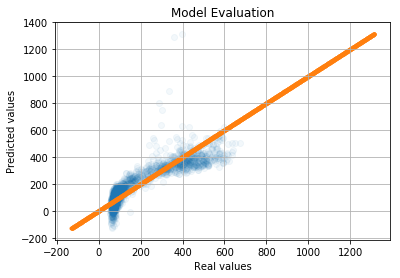

In [8]:
y_hat = model1.predict(X_test)
regression_report (y_hat, y_test)
if FLAG_EXPORT:
    plt.savefig(out_path + 'graph_error_1.svg', format='svg', dpi=1200)
    with open(out_path + 'model1.joblib', 'wb') as file: dump(model1, file)


# Extremey randomized trees

In [14]:
from sklearn.ensemble import ExtraTreesRegressor

In [10]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in range(1,25, 2):
        model = ExtraTreesRegressor(max_depth=k, n_estimators=200, max_samples=0.9).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

In [11]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in range(2, 30, 1):
        model = ExtraTreesRegressor(min_samples_split=k, n_estimators=k, max_samples=0.9).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

In [12]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in range(50,800, 50):
        model = ExtraTreesRegressor(max_depth=12, n_estimators=k, max_samples=0.9).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

In [13]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in np.arange(.6, 1.0, .02):
        model = ExtraTreesRegressor(min_samples_split=11,
                                    n_estimators=150, 
                                    max_samples=k).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

MAE:                 16.500183004575348
RMSE:                28.764504430621216
Percentual:          8.841183221421264 %


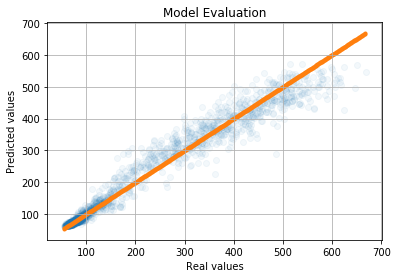

In [14]:
model2 = ExtraTreesRegressor(min_samples_split=11,
                             n_estimators=600,
                             #max_features=(int)(X_train.shape[1]*k),
                             max_samples=0.7)
model2.fit(X_train,y_train)

# TEST
y_hat = model2.predict(X_test)
regression_report (y_hat, y_test)
if FLAG_EXPORT: 
    plt.savefig(out_path + 'graph_error_2.svg', format='svg', dpi=1200)
    with open(out_path + 'model2.joblib', 'wb') as file: dump(model2, file)

# Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [16]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in np.arange(2, 10, 1):
        model = RandomForestRegressor(min_samples_split=k, 
                                    n_estimators=100, 
                                    max_samples=0.7).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

In [17]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in np.arange(1, 30, 2):
        model = RandomForestRegressor(max_depth=k, 
                                    n_estimators=100, 
                                    max_samples=0.7).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

In [18]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in np.arange(.6, 1.0, .02):
        model = RandomForestRegressor(max_depth=20, 
                                    n_estimators=100, 
                                    max_samples=k).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

MAE:                 17.214017227455773
RMSE:                30.414616534284875
Percentual:          9.223672261237168 %


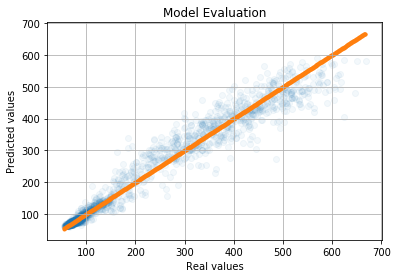

In [19]:
# Train
model3 = RandomForestRegressor(max_depth=20, n_estimators=600)#, max_features=(int)(X_train.shape[1]*1))
model3.fit(X_train,y_train)

# TEST
y_hat = model3.predict(X_test)
regression_report (y_hat, y_test)
if FLAG_EXPORT: 
    plt.savefig(out_path + 'graph_error_3.svg', format='svg', dpi=1200)
    with open(out_path + 'model3.joblib', 'wb') as file: dump(model3, file)

# Gradient boosting machines


In [20]:
from sklearn.ensemble import GradientBoostingRegressor

In [21]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in np.arange(4, 12, 2):
        model = GradientBoostingRegressor(max_depth=k,
                                          loss='huber',

                                    n_estimators=200).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

In [22]:
if FLAG_DEBUG:
    nfolds = 2
    param_grid = {
        'loss': ['ls', 'lad', 'huber', 'quantile']
    }
    grid_search = GridSearchCV(
        GradientBoostingRegressor (max_depth=8),
        param_grid,
        cv=nfolds,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    grid_search.best_params_

In [28]:
model4 = GradientBoostingRegressor(max_depth=8,
                                   loss='ls')
model4.fit(X_train,y_train)

# TEST
y_hat = model4.predict(X_test)
regression_report (y_hat, y_test)
if FLAG_EXPORT: 
    plt.savefig(out_path + 'graph_error_4.svg', format='svg', dpi=1200)
    with open(out_path + 'model4.joblib', 'wb') as file: dump(model4, file)

NameError: name 'GradientBoostingRegressor' is not defined

# SVM
* C defaut:1.  The strength of the regularization is inversely proportional to C
* gamma default = scale = 1 / (n_features * X.var())

In [24]:
from sklearn.svm import SVR

In [25]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in np.arange(50, 1000, 50):
        model = SVR(kernel='rbf',
                C=k,
                degree= 3,
                epsilon=0.5,
                gamma='scale',    
                cache_size=1000).fit(X_train,y_train)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

In [26]:
def svm_param_selection(X, y, nfolds):
    param_grid = {
        'C': [800], 
        'epsilon' : [0.4, 0.5, 0.6], 
        'kernel':['rbf']
    }
    grid_search = GridSearchCV(
        SVR(cache_size=1000),
        param_grid,
        cv=nfolds,
        verbose=2
    )
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

if FLAG_DEBUG:
    res = svm_param_selection(X,y, 2)
    res

MAE:                 19.14079467970524
RMSE:                31.314511436616346
Percentual:          10.256084597361994 %


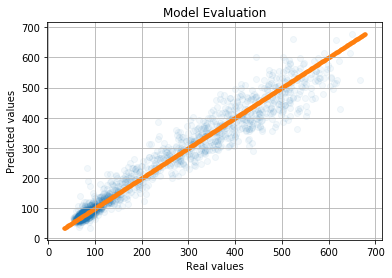

In [27]:
model5 = SVR(kernel='rbf',
            C=800,
            epsilon=0.5,
            gamma='scale',    
            cache_size=1000)
model5.fit(X_train, y_train)


y_hat = model5.predict(X_test)
regression_report (y_hat, y_test)
if FLAG_EXPORT: 
    plt.savefig(out_path + 'graph_error_5.svg', format='svg', dpi=1200)
    with open(out_path + 'model5.joblib', 'wb') as file: dump(model5, file)

# ANN
* We wrap the model to allow compatibility with Scikitlearn

In [8]:
import keras
from keras import Sequential
from keras.layers import Dropout, Dense
from keras.wrappers.scikit_learn import KerasRegressor

#utils
from keras_tqdm import TQDMNotebookCallback
from keras.models import save_model, load_model
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

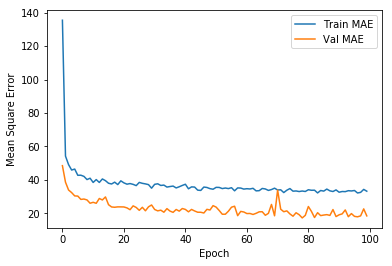

In [48]:
# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model():
    model = Sequential()
    model.add(Dense(100,activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(100,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(40,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(20,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mae',optimizer='adam', metrics=['mae'])

    return model

# wrap the model using the function you created
model6 = create_model()#KerasRegressor(build_fn=create_model,verbose=0)

# train
history = model6.fit(X_train, y_train, epochs=100, verbose=0, batch_size=16, validation_split = 0.1,
                    callbacks=[TQDMNotebookCallback()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train MAE')
plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val MAE')
plt.legend()
#plt.ylim([0,50])

MAE:                 17.83666545094228
RMSE:                30.881446382374858
Percentual:          9.575807311690902 %


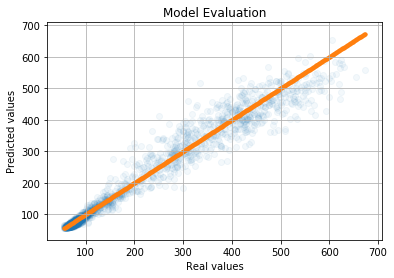

In [49]:
y_hat = model6.predict(X_test)#[:, 0]
regression_report (y_hat.reshape(len(y_hat)), y_test)
if FLAG_EXPORT: 
    plt.savefig(out_path + 'graph_error_6.svg', format='svg', dpi=1200)
    save_model(model6, out_path+'model6.h5')
    
    with open(out_path + 'ANN_model_summary.txt', 'w') as file: 
        model6.summary(print_fn=lambda line: file.write(line+'\n'))
    plot_model(model6, to_file=(out_path+'ANN_model_plot.png'), 
           show_shapes=True, 
           show_layer_names=True)

# Ensemble

In [8]:
from sklearn.ensemble import ExtraTreesRegressor
from keras.models import save_model, load_model
from joblib import dump, load

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [9]:
with open(out_path + 'model1.joblib', 'rb') as file: model1 = load(file)
with open(out_path + 'model2.joblib', 'rb') as file: model2 = load(file)
with open(out_path + 'model3.joblib', 'rb') as file: model3 = load(file)
with open(out_path + 'model4.joblib', 'rb') as file: model4 = load(file)
with open(out_path + 'model5.joblib', 'rb') as file: model5 = load(file)
model6 = load_model(out_path+'model6.h5')

estimators = [
    ('LR', model1),
    ('Extra', model2),
    ('RF', model3),
    ('GBT', model4),
    ('SVM', model5),
    ('ANN', model6)
]

W1224 00:17:19.078933 140018867226432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1224 00:17:19.492320 140018867226432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1224 00:17:19.542742 140018867226432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1224 00:17:19.543405 140018867226432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1224 00:17:19.555824

In [10]:
from stacker import Stacker


In [12]:
if FLAG_DEBUG:
    mae1 = {}
    mae2 = {}
    for k in np.arange(0.3, 1, 0.5):
        model = stacker (estimators, ExtraTreesRegressor(max_depth=10, 
                                                        n_estimators=200, 
                                                        max_samples=0.7, 
                                                        max_features=k), propagate_input=True)
        model.fit(X_train.values, y_train.values)
        y_hat = model.predict(X_train)
        mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
        y_hat = model.predict(X_test)
        mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

    plt.figure()
    #plt.plot(list(mae1.keys()), list(mae1.values()), label='Training dataset error')
    plt.plot(list(mae2.keys()), list(mae2.values()), label='Validation dataset error')
    plt.legend(loc='lower left')
    plt.xlabel("Maximun height")
    plt.ylabel("MAE")
    plt.grid(True)

In [11]:
model_L1 = ExtraTreesRegressor(max_depth=10, 
                                n_estimators=400, 
                                max_samples=0.5, 
                                max_features=0.4)
model_ensembled = Stacker (estimators, model_L1, propagate_input=True)
model_ensembled.fit(X_train.values, y_train.values)
pd.DataFrame(model_ensembled.get_L0_dataset())

predictions = model_ensembled.predict_all(X_test)

In [13]:
## Evaluate algorithm's error
errors = []
for y_hat in predictions:
    mae = abs(y_test - y_hat).sum()/len(y_test)
    rmse = math.sqrt(((y_test - y_hat)*(y_test - y_hat)).sum()/len(y_test))
    perc = mae/y_test.mean()*100
    errors.append([mae, rmse, perc])
errors = pd.DataFrame(errors, 
                   index=([name for name, model in estimators] + ['Ens.']),
                   columns=['MAE', 'RMSE', 'Perc.'])
if FLAG_EXPORT: errors.to_latex(out_path+'table_errors.tex')
errors

,MAE,RMSE,Perc.
LR,52.592044,69.696628,27.873462
Extra,16.546751,29.083576,8.769677
RF,17.240489,31.310591,9.137354
GBT,18.008763,34.531554,9.544535
SVM,20.455189,34.897529,10.841125
ANN,18.226797,31.644858,9.660091
Ens.,14.554499,25.876804,7.713795


In [ ]:
## Evaluate feature's importance/error (given by Input Perturbation Method)
perturbations = perturbation_rank(model_ensembled, X_test.values, y_test.values, X_test.columns, True).drop('importance', axis=1)
for model in [model for name, model in estimators]:
    perturbation = perturbation_rank(model, X_test.values, y_test.values, X_test.columns, True).drop('importance', axis=1)
    perturbations = pd.merge(perturbations,
                             perturbation,
                             on='name')

perturbations.columns = (['model', 'Ens.'] + [name for name, model in estimators])
perturbations = pd.merge(perturbations,
                         pd.DataFrame(np.array([np.array(X_train.columns), model1.coef_]).transpose(), columns =['model', 'LR Coeff.']),
                         on='model')

perturbations = perturbations.set_index(perturbations.model)
perturbations = perturbations.drop ('model', axis=1)
#perturbations = perturbations[['LR', 'RF', 'SVM', 'ANN', 'Ens.', 'LR Coeff.']]

if FLAG_EXPORT: perturbations.to_latex(out_path+'table_perturbations.tex')
perturbations

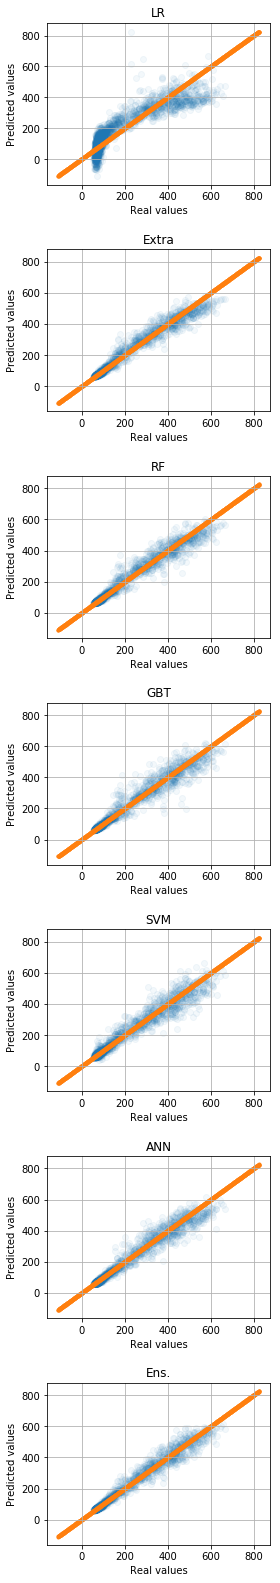

In [14]:
# Evaluate errors graphcally
l = len(predictions)
line = np.arange(min ([min (y_test), np.min(predictions)]),
                 max ([max (y_test), np.max(predictions)]),
                 1)

fig, axes = plt.subplots(l, 1, figsize=(4, 4*l))
plt.subplots_adjust(hspace = .4)
for i in range(l):
    axes[i].scatter(y_test, predictions[i], Alpha=0.05)
    axes[i].scatter(line, line, marker='.')
    
    axes[i].grid(True)
    axes[i].set_title(errors.index[i])
    axes[i].set_xlabel("Real values")
    axes[i].set_ylabel("Predicted values")
if FLAG_EXPORT: 
    plt.savefig(out_path + 'graph_error_ensembled.svg', format='svg', dpi=1200)
    with open(out_path + 'model_ensembled.joblib', 'wb') as file: dump(model_ensembled, file)